# Predicción en serie de tiempo para: Conexiones a zonas Wi-Fi - Alcaldía Mayor de Tunja

A partir de los datos abiertos publicados por la dependencia Dirección de TIC's y Gobierno digital, se realiza la analítica de los datos para crear un modelo de predicción en serie de tiempo según las conexiones en zonas Wi-Fi en total.

In [4]:
import pandas as pd


df = pd.read_csv('Informaci_n_Usuarios_Conectados_en_Zonas_Wifi_del_Municipio_de_Tunja__Boyac_.csv', parse_dates=[1])
df.head()

,ID,FECHA,HORA,ZONA,SECTOR,LATITUD,LONGITUD,ANIO,FECHA Y HORA
0,1,2021-03-01,07:05:03,POLIDEPORTIVO_SAN_AN,3,5.520588,-73.356725,2021,03/01/2021 07:05:03 AM
1,2,2021-03-01,08:09:23,POLIDEPORTIVO_SAN_AN,3,5.520588,-73.356725,2021,03/01/2021 08:09:23 AM
2,3,2021-03-01,08:20:24,POLIDEPORTIVO_SAN_AN,3,5.520588,-73.356725,2021,03/01/2021 08:20:24 AM
3,4,2021-03-01,08:35:48,POLIDEPORTIVO_SAN_AN,3,5.520588,-73.356725,2021,03/01/2021 08:35:48 AM
4,5,2021-03-01,09:12:06,POLIDEPORTIVO_SAN_AN,3,5.520588,-73.356725,2021,03/01/2021 09:12:06 AM


Se agrupan todas las conexiones de todas las zonas Wi-Fi de Tunja discriminando por dia.

In [15]:
df1 = df.groupby(df['FECHA'].dt.date).size().reset_index(name='CONEXIONES')
df1.head()

,FECHA,CONEXIONES
0,2021-03-01,381
1,2021-03-02,416
2,2021-03-03,491
3,2021-03-04,371
4,2021-03-05,484


In [25]:
df1['FECHA'] = df1['FECHA'].astype(str)
df1['CONEXIONES'] = df1['CONEXIONES'].astype(str)
df1.dtypes


FECHA         object
CONEXIONES    object
dtype: object

Por medio de DARTS se crea una serie de tiempo de los datos, donde su gráfica se muestra como sigue

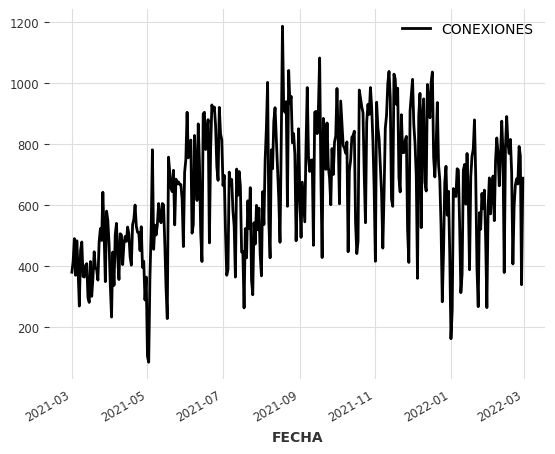

In [30]:
from darts import TimeSeries
series = TimeSeries.from_dataframe(df1, 'FECHA', 'CONEXIONES')
series.plot()

Se dividen los datos para entrenamiento del modelo y validación según muestra la gráfica

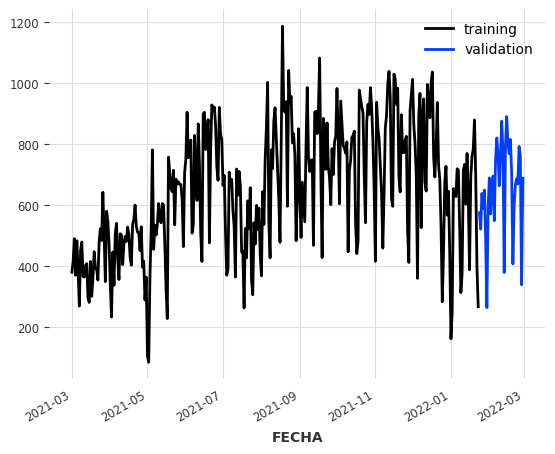

In [34]:
train, val = series.split_after(0.8)

train.plot(label="training")
val.plot(label="validation")

Se usa un modelo exponencial para inferir predicciones

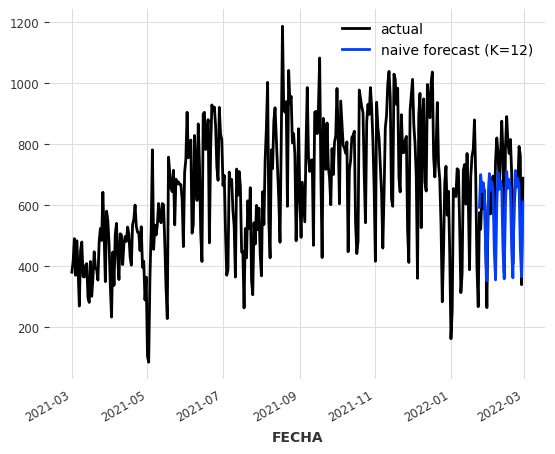

In [39]:
from darts.models import ExponentialSmoothing
model = ExponentialSmoothing()
model.fit(train)
pred = model.predict(len(val))
series.plot(label="actual")
pred.plot(label="Exponential")

Si vemos en la gráfica el modelo no se ajusta totalmente a los resultados de validación, por lo que, se usa otro modelo para inferir un mejor resultado. De varios modelos calculamos el error porcentual absoluto medio (MAPE)

In [44]:
from darts.models import ExponentialSmoothing, TBATS, AutoARIMA, Theta
from darts.metrics import mape

def eval_model(model):
    model.fit(train)
    forecast = model.predict(len(val))
    print("model {} obtains MAPE: {:.2f}%".format(model, mape(val, forecast)))


eval_model(ExponentialSmoothing())
eval_model(TBATS())
eval_model(AutoARIMA())
eval_model(Theta())

model ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7 obtains MAPE: 15.04%
model (T)BATS obtains MAPE: 13.29%
model Auto-ARIMA obtains MAPE: 23.39%
model Theta(2) obtains MAPE: 19.79%


De los modelos anteriores se deduce que el menor error de inferencia se encuentra usando el modelo (T)BATS, por lo tanto se usa el modelo para predecir.

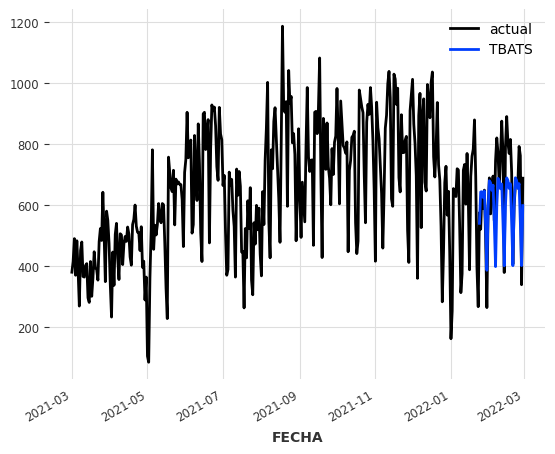

In [46]:
model = TBATS()
model.fit(train)
pred = model.predict(len(val))
series.plot(label="actual")
pred.plot(label="TBATS")

Sin embargo, la diferencia de error con el modelo exponencial no es significante. Ahora probamos un modelo difente. Donde `K = 12` debido a que los datos pueden presentar un ciclo cada doce meses 

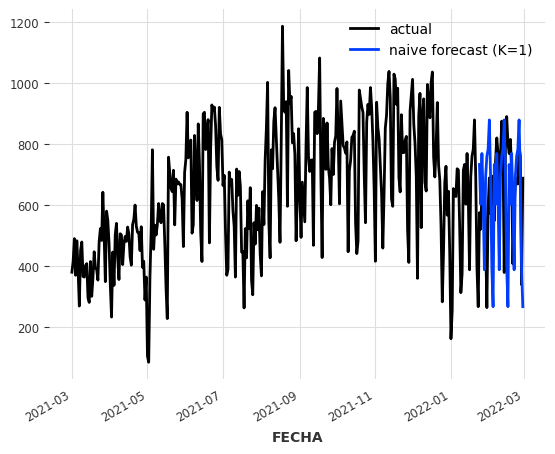

In [41]:
from darts.models import NaiveSeasonal

naive_model = NaiveSeasonal(K=12)
naive_model.fit(train)
naive_forecast = naive_model.predict(len(val))

series.plot(label="actual")
naive_forecast.plot(label="naive forecast (K=1)")

In [53]:
eval_model(NaiveSeasonal(K=12))

model Naive seasonal model, with K=12 obtains MAPE: 32.97%


El error que se muestra es mayor para un modelo ajustado por ciclo, como última instancia, se entrena el modelo basado en Deep Learning usando los datos de entrenamiento. Hay que tener en cuenta que, debido al rango de tiempo que se dispone para entrenar es más dificil para el modelo ajustarse a la gráfica de predicción

In [54]:
from darts.models import NBEATSModel

model_beats = NBEATSModel(input_chunk_length=24, output_chunk_length=12, random_state=42)

model_beats.fit([train], epochs=50, verbose=True);


2022-09-15 14:45:52 pytorch_lightning.utilities.rank_zero INFO: GPU available: False, used: False
2022-09-15 14:45:52 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-09-15 14:45:52 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-09-15 14:45:52 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
2022-09-15 14:45:52 pytorch_lightning.callbacks.model_summary INFO: 
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 6.2 M 
---------------------------------------------------
6.2 M     Trainable params
1.4 K     Non-trainable params
6.2 M     Total params
49.575    Total estimated model params size (MB)


Epoch 49: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s, loss=878, train_loss=567.0]       

2022-09-15 14:48:31 pytorch_lightning.utilities.rank_zero INFO: `Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s, loss=878, train_loss=567.0]


Ahora vamos a usar el modelo para predecir datos de la serie de tiempo para los proximos 30 dias

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  4.85it/s]


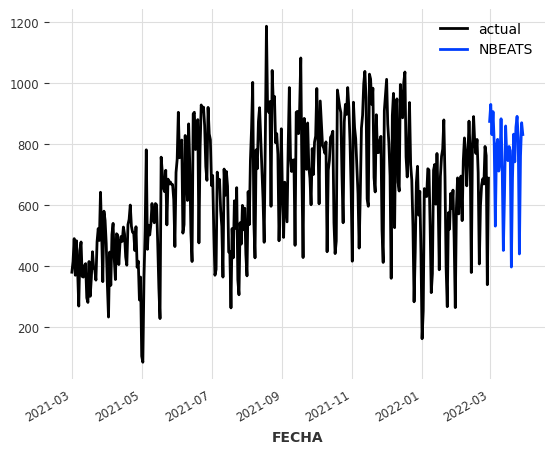

In [60]:
pred = model_beats.predict(30, series=series)
series.plot(label="actual")
pred.plot(label="NBEATS")

In [69]:
pred.min(axis = 0)

<TimeSeries (DataArray) (FECHA: 1, component: 1, sample: 1)>
array([[[397.92453377]]])
Coordinates:
  * FECHA      (FECHA) datetime64[ns] 2022-03-01
  * component  (component) object 'CONEXIONES'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [70]:
pred.max(axis = 0)

<TimeSeries (DataArray) (FECHA: 1, component: 1, sample: 1)>
array([[[930.73310477]]])
Coordinates:
  * FECHA      (FECHA) datetime64[ns] 2022-03-01
  * component  (component) object 'CONEXIONES'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [68]:
pred.mean(axis = 0)

<TimeSeries (DataArray) (FECHA: 1, component: 1, sample: 1)>
array([[[756.96163847]]])
Coordinates:
  * FECHA      (FECHA) datetime64[ns] 2022-03-01
  * component  (component) object 'CONEXIONES'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

Según la estimación se espera que las conexiones aumenten, dando un promedio de 757 conexiones en los próximos 30 días, donde, el día en que menos conexiones hay, en total habran 398 conexiones